This notebook is based entirely on the knowledge which I gained from doing the Machine Learning courses on Kaggle and reading sklearn/pandas documentation.  

I tried here to create an automated pipeline for feature preparation, which does:
- remove numerical columns with a large amount of missing data,
- impute missing data in categorical columns and in the numerical columns which have most entries and a small part of missing data,
- removes features have small mutual information with the target,
- creates new features by applying PCA to numerical features,
- performs One Hot Encoding on the categorical data.

Next, the preprocessed data is fed into a simple XGBRegressor model, which can be run with early stopping rounds, when performed on the train/validations sets.



In [1]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error
from sklearn.feature_selection import mutual_info_regression
from sklearn.preprocessing import OneHotEncoder
from xgboost import XGBRegressor
from sklearn.decomposition import PCA

# Read the data
X = pd.read_csv('../input/home-data-for-ml-course/train.csv', index_col='Id') 
X_test = pd.read_csv('../input/home-data-for-ml-course/test.csv', index_col='Id')

# Remove rows with missing target, separate target from predictors
X.dropna(axis=0, subset=['SalePrice'], inplace=True)
y = X.SalePrice
X.drop(['SalePrice'], axis=1, inplace=True)

# Break off validation set from training data
X_train, X_valid, y_train, y_valid = train_test_split(X, y,
                                                      train_size=0.8, test_size=0.2,
                                                      random_state=0)

First, analyze general facts about the data (if there are missing values and what types of data occur) and check for outliers using PCA.

In [2]:
print(f'There is a total of {len(X.columns)} features.')

cols_with_missing = set([col for col in X.columns if X[col].isnull().any()])
cols_with_missing.update([col for col in X_test.columns if X_test[col].isnull().any()])
print(f'There are {len(cols_with_missing)} features with missing entries in the training and test set.')

cat = (X.dtypes == 'object')
categorical_cols = list(cat[cat].index)
print(f'There are {len(categorical_cols)} categorical features.')

num = (X.dtypes != 'object')
num_cols = list(num[num].index)
print(f'There are {len(num_cols)} numerical features.')

There is a total of 79 features.
There are 34 features with missing entries in the training and test set.
There are 43 categorical features.
There are 36 numerical features.


The first 10 PCA components explain these amounts of variance:
[0.19386639 0.09564245 0.06510423 0.05987158 0.04440183 0.03584957
 0.03483578 0.03356583 0.03259043 0.03155213]


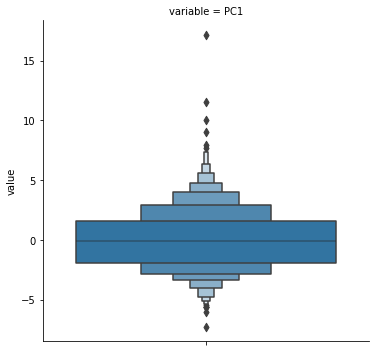

In [3]:
pca_features = [col for col in num_cols if not X[col].isnull().any()]

def apply_pca(X, standardize=True):
    if standardize:
        X = (X - X.mean(axis=0)) / X.std(axis=0)
    pca = PCA()
    X_pca = pca.fit_transform(X)
    component_names = [f"PC{i+1}" for i in range(X_pca.shape[1])]
    X_pca = pd.DataFrame(X_pca, columns=component_names)
    loadings = pd.DataFrame(
        pca.components_.T,  # transpose the matrix of loadings
        columns=component_names,  # so the columns are the principal components
        index=X.columns,  # and the rows are the original features
    )
    return pca, X_pca, loadings

pca, X_pca, loadings = apply_pca(X[pca_features])

print('The first 10 PCA components explain these amounts of variance:')
print(pca.explained_variance_ratio_[:10])

component_to_see = 'PC1'
distribution = X_pca.melt()
distribution = distribution.loc[distribution['variable'] == component_to_see]

sns.catplot(
    y="value",
    col="variable",
    data=distribution,
    kind='boxen',
    sharey=False,
    col_wrap=2,
);

Below, I define the function which will preprocess data. It takes as arguments: 
- a train set `X` 
- a test/validation set `X_test` 
- the target output as `y`.  

It works on copies of the `X` and `X_test` data, and returns these two datasets after completing all preprocessing steps, which include:
- removing numerical columns which have more than `missing_threshold` missing entries,
- imputing missing data in the rest of the numerical columns with missing data using the median value or 0,
- imputing missing data in categorical columns with a new value (often the NaN in categorical data has the meaning of a new category, e.g. "the absence of a garage") 
- removing features have mutual information with the target smaller than `mutual_inf_threshold`,
- creates new features by applying PCA to existing numerical features and then adding as new features the first `pca_components_to_include` components
- dropping categorical data that have cardinality larger than `low_cardinality_threshold`,
- performing One Hot Encoding on the low-cardinality categorical data.


In [4]:
def make_mi_scores(X, y, discrete_features):
    mi_scores = mutual_info_regression(X, y, discrete_features=discrete_features)
    mi_scores = pd.Series(mi_scores, name="MI Scores", index=X.columns)
    mi_scores = mi_scores.sort_values(ascending=False)
    return mi_scores

def preprocessing_pipeline(X, y, X_test, 
                           missing_threshold=100, 
                           mutual_inf_threshold=0.05, 
                           low_cardinality_threshold=15,
                           pca_components_to_include=10,
                           verbose = False):
    
    data = X.copy()
    data_test = X_test.copy()
    
    if verbose:
        print('**************************')
        print('\nNumber of features at the beginning:')
        print(len(data.columns))
        print(len(data_test.columns))
    
    #--- Impute missing values
    cols_with_missing = set([col for col in data.columns if data[col].isnull().any()])
    cols_with_missing.update([col for col in data_test.columns if data_test[col].isnull().any()])
    if verbose:
        print('Columns with missing values: ')
        print(cols_with_missing)
    
    cols_to_drop = [col for col in cols_with_missing if data[col].isnull().sum()>missing_threshold] 
    cols_with_missing_num = [col for col in cols_with_missing if data[col].isnull().sum()<missing_threshold and data[col].dtype != "object"] 
    cols_with_missing_cat = [col for col in cols_with_missing if data[col].isnull().sum()<missing_threshold and data[col].dtype == "object"]
    
    if verbose:
        print('\n Columns which will be dropped due to a lot of missing values: ')
        print(cols_to_drop)
    data = data.drop(cols_to_drop, axis=1)
    data_test = data_test.drop(cols_to_drop, axis=1)
    
    if verbose:
        print('\nNumber of features after dropping missing values:')
        print(len(data.columns))
        print(len(data_test.columns))
    
    for column in cols_with_missing_num:
        if column == 'LotFrontage':
            data[column] = data[column].fillna(data[column].median())
            data_test[column] = data_test[column].fillna(data_test[column].median())
        else:
            data[column] = data[column].fillna(0)
            data_test[column] = data_test[column].fillna(0)
    
    for column in cols_with_missing_cat:
        data[column] = data[column].fillna('N')
        data_test[column] = data_test[column].fillna('N')
    
    imputed = data.copy()
    imputed_test = data_test.copy()

    imputed.columns = data.columns
    imputed_test.columns = data_test.columns
    
    if verbose:
        print('\nNumber of features after imputation:')
        print(len(imputed.columns))
        print(len(imputed_test.columns))
    
    #--- Throw away numerical features which have very small mutual information with target
    num = (data.dtypes != 'object')
    num_cols = list(num[num].index)
    
    mi_scores = make_mi_scores(imputed[num_cols], y, 'auto')
    if verbose:
        print('\nNumerical features with highest mutual information with target: ')
        print(mi_scores)
    
    unimportant_columns = [index for index,score in mi_scores.iteritems() if score < mutual_inf_threshold]
    if verbose:
        print('\nColumns which will be dropped: ')
        print(unimportant_columns)
    
    high_mi = imputed.drop(unimportant_columns, axis=1)
    high_mi_test = imputed_test.drop(unimportant_columns, axis=1)
    
    if verbose:
        print('\nNumber of features after dropping low MI features:')
        print(len(high_mi.columns))
        print(len(high_mi_test.columns))
    
    #--- Apply PCA to numerical features
    important_num_columns = list(set(num_cols) - set(unimportant_columns))
    pca, X_pca, loadings = apply_pca(high_mi[important_num_columns], standardize=False)
    pca_test, X_pca_test, loadings_test = apply_pca(high_mi_test[important_num_columns],standardize=False)

    first_n_components = [f"PC{i+1}" for i in range(pca_components_to_include)]
    data_after_pca = high_mi.join(X_pca[first_n_components])
    data_after_pca_test = high_mi_test.join(X_pca_test[first_n_components])

    if verbose:
        print('\nNumber of features after adding PCA components:')
        print(len(data_after_pca.columns))
        print(len(data_after_pca_test.columns))
        
    #--- Encode categorical features
    
    cat = (high_mi.dtypes == 'object')
    categorical_cols = list(cat[cat].index)
    low_cardinality_cols = [col for col in categorical_cols if data_after_pca[col].nunique() < low_cardinality_threshold]
    high_cardinality_cols = list(set(categorical_cols)-set(low_cardinality_cols))
    
    lc_X_train = data_after_pca.drop(high_cardinality_cols, axis=1)
    lc_X_valid = data_after_pca_test.drop(high_cardinality_cols, axis=1)
    
    OH_encoder = OneHotEncoder(handle_unknown='ignore', sparse=False)
    OH_cols_train = pd.DataFrame(OH_encoder.fit_transform(lc_X_train[low_cardinality_cols]))
    OH_cols_valid = pd.DataFrame(OH_encoder.transform(lc_X_valid[low_cardinality_cols]))
    
    OH_cols_train.index = data_after_pca.index
    OH_cols_valid.index = data_after_pca_test.index
    num_X_train = data_after_pca.drop(categorical_cols, axis=1)
    num_X_valid = data_after_pca_test.drop(categorical_cols, axis=1)
    OH_X = pd.concat([num_X_train, OH_cols_train], axis=1)
    OH_X_test = pd.concat([num_X_valid, OH_cols_valid], axis=1)
    
    if verbose:
        print('\nNumber of features after OHE:')
        print(len(OH_X.columns)) 
        print(len(OH_X_test.columns))
    
    return OH_X, OH_X_test

Next, four loops are run to find the optimal values of the hyperparameters of the preprocessing pipeline. 
Note that XGBRegressor is run with early stopping rounds to speed up the evaluation.

In [5]:
smallest_mae = 30_000

for missing_threshold in [100, 500, 1000]:
    for mutual_inf_threshold in [0, 0.05, 0.1, 0.15]:
        for low_cardinality_threshold in [10, 30, 40]:
            for pca_components_to_include in [0, 10]:
                print(f'running: {missing_threshold}, {mutual_inf_threshold}, {low_cardinality_threshold}, {pca_components_to_include}')

                processed_X_train, processed_X_valid = preprocessing_pipeline(X_train, y_train, X_valid, 
                                                                              missing_threshold=missing_threshold,      
                                                                              mutual_inf_threshold=mutual_inf_threshold, 
                                                                              low_cardinality_threshold=low_cardinality_threshold,
                                                                              pca_components_to_include=pca_components_to_include)
                
                model = XGBRegressor(n_estimators=5_000, learning_rate = 0.02)
                model.fit(processed_X_train, y_train, early_stopping_rounds=10, 
                          eval_set=[(processed_X_valid, y_valid)],verbose=False)
                preds_test = model.predict(processed_X_valid)

                print('**********************************************')
                print(missing_threshold)
                print(mutual_inf_threshold)
                print(low_cardinality_threshold)
                mae = mean_absolute_error(y_valid, preds_test)
                print(mae)
                if mae < smallest_mae:
                    smallest_mae = mae
                    best_params = missing_threshold, mutual_inf_threshold, low_cardinality_threshold, pca_components_to_include

print(smallest_mae)
print(best_params)

running: 100, 0, 10, 0
**********************************************
100
0
10
16601.47709760274
running: 100, 0, 10, 10
**********************************************
100
0
10
17022.426102311645
running: 100, 0, 30, 0
**********************************************
100
0
30
16085.441152076199
running: 100, 0, 30, 10
**********************************************
100
0
30
16514.491331335616
running: 100, 0, 40, 0
**********************************************
100
0
40
16085.441152076199
running: 100, 0, 40, 10
**********************************************
100
0
40
16514.491331335616
running: 100, 0.05, 10, 0
**********************************************
100
0.05
10
16647.255377782534
running: 100, 0.05, 10, 10
**********************************************
100
0.05
10
16491.619715860445
running: 100, 0.05, 30, 0
**********************************************
100
0.05
30
16200.106900149829
running: 100, 0.05, 30, 10
**********************************************
100
0.05
30
15929.17132

In [6]:
import numpy as np
processed_X_train, processed_X_valid = preprocessing_pipeline(X_train, y_train, X_valid, 
                                                       missing_threshold=best_params[0],      
                                                       mutual_inf_threshold=best_params[1],
                                                       low_cardinality_threshold=best_params[2],
                                                       pca_components_to_include=best_params[3])
print(len(processed_X_train.columns), len(processed_X_valid.columns))

model = XGBRegressor(n_estimators = 5_000, learning_rate = 0.02)
model.fit(processed_X_train, y_train)
preds_test = model.predict(processed_X_valid)
mae = mean_absolute_error(y_valid, preds_test)


270 270


Finally, the best parameters will be used to the generate predictions on the entire training set.

In [7]:
processed_X, processed_X_test = preprocessing_pipeline(X, y, X_test, 
                                                       missing_threshold=best_params[0],      
                                                       mutual_inf_threshold=best_params[1],
                                                       low_cardinality_threshold=best_params[2])
print(len(processed_X.columns), len(processed_X_test.columns))

model = XGBRegressor(n_estimators = 5_000, learning_rate = 0.02)
model.fit(processed_X, y)
preds_test = model.predict(processed_X_test)

output = pd.DataFrame({'Id': X_test.index,
                       'SalePrice': preds_test})
output.to_csv('submission.csv', index=False)
print('output saved')

275 275
output saved


The last thing which remains would be optimize the XGBRegressor parameters, e.g. using GridSearchCV.